In [1]:
TEST_SIZE = 0.20
RANDOM_STATE = 42
BATCH_SIZE = 1024
EPOCHS = 20
LR = 1e-3
DEVICE = None  # 'cuda' ou 'cpu'

from sklearn.preprocessing import StandardScaler

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False


from sklearn.metrics import roc_auc_score
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTEENN
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef
import pandas as pd
import seaborn as sn
import kagglehub as kh
import matplotlib.pyplot as plt
import os
import numpy as np     

import warnings
warnings.filterwarnings('ignore')

print(f"Torch disponível: {TORCH_AVAILABLE}")

/home/ubuntu-user/anaconda3/lib/python3.12/site-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


Torch disponível: True


In [2]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")
print("Caminho para o Dataset:", path)
os.listdir(path)

df = pd.read_csv("/home/ubuntu-user/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv")
df.tail()

print("Caminho para o Dataset:", path)
os.listdir(path)

print('Formato do dataset:', df.shape)
print(df['Class'].value_counts())

expected_pca = [f'V{i}' for i in range(1,29)]
missing = [c for c in expected_pca if c not in df.columns]
if missing:
    print('Aviso: colunas PCA ausentes:', missing)

features = [c for c in df.columns if c != 'Class']
X = df[features].copy()
y = df['Class'].copy()

scaler = StandardScaler()
if 'Amount' in X.columns:
    X['Amount'] = scaler.fit_transform(X[['Amount']])
if 'Time' in X.columns:
    X['Time'] = scaler.fit_transform(X[['Time']])

X = X.fillna(0)


Caminho para o Dataset: /home/ubuntu-user/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Caminho para o Dataset: /home/ubuntu-user/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Formato do dataset: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print('Treino:', X_train.shape, 'Teste:', X_test.shape)
print('Distribuição treino:\n', y_train.value_counts(normalize=True))

Treino: (227845, 30) Teste: (56962, 30)
Distribuição treino:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


In [4]:
def ratio_to_sampling_strategy(minority_pct, majority_pct):
    return (minority_pct / majority_pct)

def compute_metrics(y_true, y_pred, y_proba=None):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return dict(precision=p, recall=r, f1=f1, accuracy=acc, mcc=mcc, auc=auc)

if TORCH_AVAILABLE:
    class FraudDatasetTorch(Dataset):
        def __init__(self, X, y=None):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = None if y is None else torch.tensor(y.values, dtype=torch.float32)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            if self.y is None:
                return self.X[idx]
            return self.X[idx], self.y[idx]

    class SimpleMLP(nn.Module):
        def __init__(self, input_dim, hidden_layers=[64,32], dropout=0.2):
            super().__init__()
            layers = []
            prev = input_dim
            for h in hidden_layers:
                layers.append(nn.Linear(prev, h))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
                prev = h
            layers.append(nn.Linear(prev, 1))
            layers.append(nn.Sigmoid())
            self.model = nn.Sequential(*layers)
        def forward(self, x):
            return self.model(x).squeeze(1)

    def train_pytorch_mlp(X_tr, y_tr, X_val, y_val, input_dim, hidden_layers=[64,32],
                          epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, device=None):
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = SimpleMLP(input_dim, hidden_layers=hidden_layers).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_ds = FraudDatasetTorch(X_tr, y_tr)
        val_ds = FraudDatasetTorch(X_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        best_model = None
        best_auc = -np.inf

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
            # Validação simples
            model.eval()
            ys, ps = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    ys.append(yb.cpu().numpy())
                    ps.append(out.cpu().numpy())
            ys = np.concatenate(ys)
            ps = np.concatenate(ps)
            auc = roc_auc_score(ys, ps)
            if auc > best_auc:
                best_auc = auc
                best_model = model.state_dict()
            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} AUC={auc:.4f}")

        model.load_state_dict(best_model)
        return model, device

    def predict_pytorch(model, device, X):
        model.eval()
        ds = FraudDatasetTorch(X, None)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
        preds = []
        with torch.no_grad():
            for xb in loader:
                xb = xb.to(device)
                out = model(xb)
                preds.append(out.cpu().numpy())
        return np.concatenate(preds)


In [5]:
summary_rows = []
roc_data = {}

print('SMOTE-ENN 10 : 90')
smt = SMOTEENN(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm_1090)
print('Amostra balanceada:', np.bincount(y_train_sm_1090.astype(int).))

if TORCH_AVAILABLE:
    model, device = train_pytorch_mlp(X_train_sm_1090, y_train_sm_1090, X_test, y_test, input_dim=X_train_sm_1090.shape[1])
    y_proba = predict_pytorch(model, device, X_test)
    y_pred = (y_proba >= 0.5).astype(int)
else:
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=RANDOM_STATE)
    mlp.fit(X_train_sm_1090, y_train_sm_1090)
    y_pred = mlp.predict(X_test)
    y_proba = mlp.predict_proba(X_test)[:,1]

metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{10}:{90}", model='FNN', **metrics))
roc_data[f"{10}:{90}"] = y_proba

SMOTE-ENN 10 : 90
Amostra balanceada: [227074  25243]
Epoch 1/20 AUC=0.9819
Epoch 10/20 AUC=0.9791
Epoch 20/20 AUC=0.9765


In [6]:
summary_df = pd.DataFrame(summary_rows)
print('\nResumo das métricas:')
print(summary_df)


Resumo das métricas:
   ratio model  precision    recall        f1  accuracy       mcc       auc
0  10:90   FNN   0.696721  0.867347  0.772727  0.999122  0.776948  0.976466


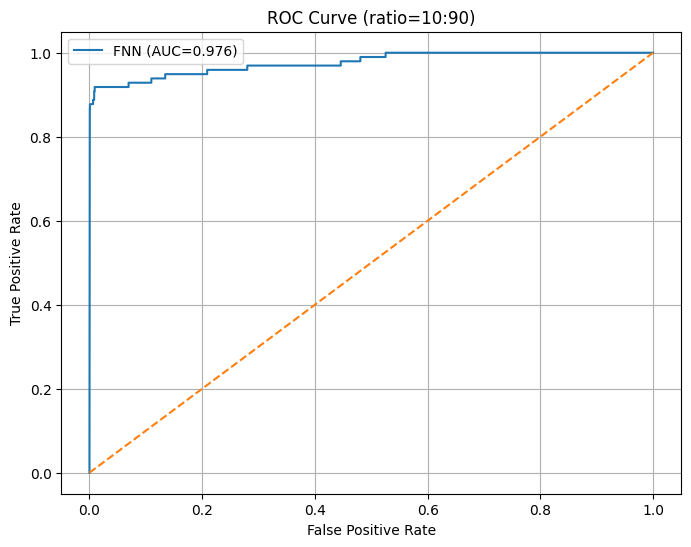

In [7]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
summary_rows = []
roc_data = {}

print('SMOTE-ENN 50 : 50')
smt = SMOTEENN(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm_5050)
print('Depois do SMOTE-ENN:', counter)

print('Amostra balanceada:', np.bincount(y_train_sm_5050.astype(int)))

if TORCH_AVAILABLE:
    model, device = train_pytorch_mlp(X_train_sm_5050, y_train_sm_5050, X_test, y_test, input_dim=X_train_sm_5050.shape[1])
    y_proba = predict_pytorch(model, device, X_test)
    y_pred = (y_proba >= 0.5).astype(int)
else:
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=RANDOM_STATE)
    mlp.fit(X_train_sm_5050, y_train_sm_5050)
    y_pred = mlp.predict(X_test)
    y_proba = mlp.predict_proba(X_test)[:,1]

metrics = compute_metrics(y_test, y_pred, y_proba)
summary_rows.append(dict(ratio=f"{50}:{50}", model='FNN', **metrics))
roc_data[f"{50}:{50}"] = y_proba


SMOTE-ENN 50 : 50
Depois do SMOTE-ENN: Counter({1: 227451, 0: 227054})
Amostra balanceada: [227054 227451]
Epoch 1/20 AUC=0.9790
Epoch 10/20 AUC=0.9720
Epoch 20/20 AUC=0.9706


In [9]:
# summary_rows = []
# roc_data = {}
# train_losses = []
# val_losses = []

# for ratio in SMOTEENN_RATIOS:
#     minor_pct, maj_pct = ratio
#     sampling_strategy = ratio_to_sampling_strategy(minor_pct, maj_pct)
#     print(f"\n--- Treinando FNN com razão {minor_pct}:{maj_pct} ---")

#     sampler = SMOTEENN(smote=SMOTE(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE),
#                        random_state=RANDOM_STATE)

#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
#     print('Amostra balanceada:', np.bincount(y_resampled.astype(int)))

#     if TORCH_AVAILABLE:
#         model, device = train_pytorch_mlp(X_resampled, y_resampled, X_resampled, y_resampled, input_dim=X_resampled.shape[1])
#         y_proba = predict_pytorch(model, device, X_test)
#         y_pred = (y_proba >= 0.5).astype(int)
#     else:
#         from sklearn.neural_network import MLPClassifier
#         mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=RANDOM_STATE)
#         mlp.fit(X_resampled, y_resampled)
#         y_pred = mlp.predict(X_test)
#         y_proba = mlp.predict_proba(X_test)[:,1]

#     metrics = compute_metrics(y_test, y_pred, y_proba)
#     summary_rows.append(dict(ratio=f"{minor_pct}:{maj_pct}", model='FNN', **metrics))
#     roc_data[f"{minor_pct}:{maj_pct}"] = y_proba


In [10]:
summary_df = pd.DataFrame(summary_rows)
print('\nResumo das métricas:')
print(summary_df)


Resumo das métricas:
   ratio model  precision    recall        f1  accuracy       mcc       auc
0  50:50   FNN   0.613139  0.857143  0.714894  0.998824  0.724407  0.970649


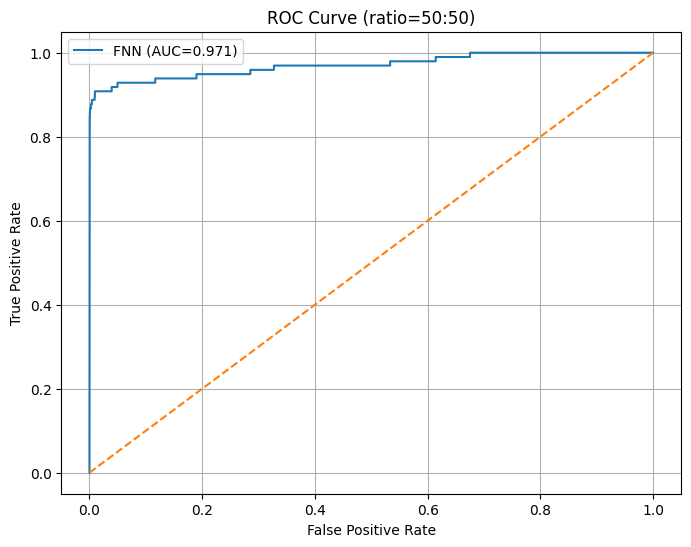

In [11]:
last_ratio = list(roc_data.keys())[-1]
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, roc_data[last_ratio])
auc_val = roc_auc_score(y_test, roc_data[last_ratio])
plt.plot(fpr, tpr, label=f"FNN (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (ratio={last_ratio})')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
summary_df.to_csv('fnn_results_summary.csv', index=False)
print('Resultados salvos em fnn_results_summary.csv')

Resultados salvos em fnn_results_summary.csv
